# LVC GW Targets

Generate a target list of host galaxies given the 50% and 90% credible localization regions of a GW alert.

In [1]:
from astropy.io import fits
from astropy.table import Table

import healpy as hp

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from gw_skymap import compute_quantiles, compute_contours, plot_gwmap

from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap, check_hp_target_dir
from desitarget.targetmask import desi_mask, bgs_mask

## Read GW LALInference Map

Extract localization PDF for a GW event and plot it using the DESI footprint.

Data can be downloaded from the [LVC GraceDB public alert page](https://gracedb.ligo.org/).

In [2]:
fits_file = 'GW190412_skymap.fits.gz'

# Read metadata.
hdus = fits.open(fits_file)
header = hdus[1].header

# instruments = header['INSTRUME']
distmean = header['DISTMEAN']
diststd = header['DISTSTD']
origin = header['ORIGIN']
date = header['DATE']

gwmap = hp.read_map(fits_file)
npix = len(gwmap)
nside = hp.npix2nside(npix)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  

In [3]:
# Compute GW quantiles.
levels = [0.50, 0.90]
lev50, lev90 = compute_quantiles(levels, gwmap)
print(levels, lev50, lev90)

# # Compute GW quantiles for degraded map.
# gwmap64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
# gwmap64 = gwmap64/np.sum(gwmap64)
# lev50, lev90 = compute_quantiles(levels, gwmap64)
# print(levels, lev50, lev90)

[0.5, 0.9] 0.0002977923419504475 5.45145832371135e-05


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 45 deg 0.00'.
  warnings.warn(


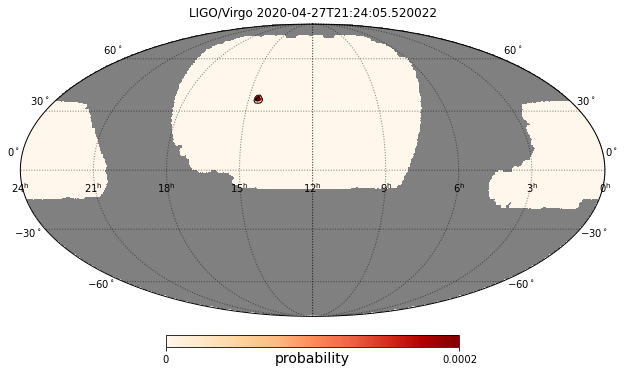

In [4]:
fig = plot_gwmap('GW190412_skymap.fits.gz', levels=[0.5, 0.9])
fig.savefig('gw_skymap.png', dpi=100)

In [5]:
maxpix = np.argmax(gwmap)
ra_c, dec_c = hp.pix2ang(nside, maxpix, lonlat=True)
print(ra_c, dec_c)

218.49609375 36.469945487867896


## Load DR8 Targets

Using the code from the [DESI target example notebook](https://github.com/qmxp55/desi_uk_meeting_2019/blob/master/desitarget_local_example.ipynb) created by Omar Macias, extract the targets within a box surrounding the 90% C.I.

In [6]:
# pixids = hp.ring2nest(64, np.arange(len(gwmap64)))
# pix50 = pixids[gwmap64 > lev50]
# pix90 = pixids[gwmap64 > lev90]

pixids = hp.ring2nest(nside, np.arange(npix))
pix50 = pixids[gwmap > lev50]
pix90 = pixids[gwmap > lev90]

In [7]:
# Load sample of resolved DR8 target catalog using HEALPixels above threshold in the GW map.
hpdirname = '/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/dark'
targ90 = Table(read_targets_in_hp(hpdirname, nside=nside, pixlist=pix90))

In [8]:
len(targ90)

47955

In [9]:
bgs_mask_bits = '|'.join([_ for _ in bgs_mask.names() if 'BGS' in _])
bgs_mask_bits 

'BGS_FAINT|BGS_BRIGHT|BGS_WISE|BGS_FAINT_HIP|BGS_FAINT_NORTH|BGS_BRIGHT_NORTH|BGS_WISE_NORTH|BGS_FAINT_SOUTH|BGS_BRIGHT_SOUTH|BGS_WISE_SOUTH'

### Select Targets

Identify targets within the 50% and 90% contours, and apply a basic cut on bright BGS objects.

In [10]:
bgs_targets = (targ90['BGS_TARGET'] & bgs_mask.mask(bgs_mask_bits)) != 0
ra90, dec90 = [targ90[_][bgs_targets] for _ in ['RA', 'DEC']]

rmag = 22.5 - 2.5*np.log10(targ90['FLUX_R'][bgs_targets])
rthr = np.max(rmag)
print('{:8d} targets in 90% C.I. with rmag > {:g}'.format(len(ra90), rthr))

    7051 targets in 90% C.I. with rmag > 20.0498


### Plot the Targets

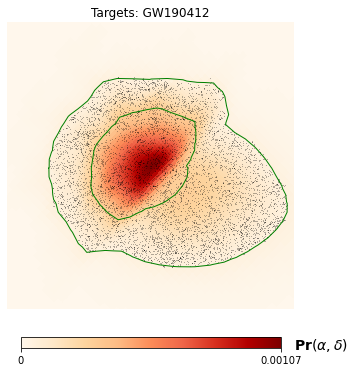

In [12]:
# fig = plt.figure(1, figsize=(4,6))

hp.cartview(gwmap, fig=1, cmap='OrRd',
            lonra=[ra_c-360-3,ra_c-360+3],
            latra=[dec_c-3,dec_c+3],
            min=0, max=np.max(gwmap),
            title='Targets: GW190412', unit=r'Pr$(\alpha,\delta)$', flip='astro')
# hp.projplot(ra50, dec50, 'k,', alpha=0.1, lonlat=True);
hp.projplot(ra90, dec90, 'k,', alpha=0.3, lonlat=True);

# Compute GW contours for degraded map.
# gwmap64 = hp.pixelfunc.ud_grade(gwmap, 64) #reduce nside to make it faster
# gwmap64 = gwmap64/np.sum(gwmap64)
# ra_contour, dec_contour = compute_contours(levels, gwmap64)
gwmap256 = hp.pixelfunc.ud_grade(gwmap, 256) #reduce nside to make it faster
gwmap256 = gwmap256/np.sum(gwmap256)
ra_contour, dec_contour = compute_contours(levels, gwmap256)
for i, (rc, dc) in enumerate(zip(ra_contour, dec_contour)):
    hp.projplot(rc, dc, lonlat=True, linewidth=1, c='g')
    
fig = plt.gcf()
fig.savefig('targlist.png', dpi=150)

In [13]:
targ90[bgs_targets]

RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,RA,RA_IVAR,DEC,DEC_IVAR,DCHISQ [5],EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,REF_EPOCH,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,PHOTSYS,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SUBPRIORITY,OBSCONDITIONS,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL
int16,int32,str8,int32,str4,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,int8,float32,float32,float32,float32,float32,float32,str1,int64,int64,int64,int64,float64,int64,int64,int64,int64
8001,525473,2199p360,408,DEV,220.03761697754447,544012470000.0,35.895835596171075,647907400000.0,25363.068 .. 29613.14,0.011451967,2.5636055,12.993189,29.336231,239.6683,51.1536,22.45993,0.966668,0.9774231,0.987308,0.0,0.0,0.0,0.018250892,0.015823884,0.010914577,0.99245745,0.99376315,0.99470985,3,3,2,661.5222,193.26424,92.3982,445.99286,119.59604,40.26458,47.238106,31.326277,23.178545,-239.1024,4.160369,0.8252489,0.0025527088,3.2343083e-05,0.9980611,0.9988088,0.99974585,0.99990404,0,0,0,1.0993375,5.5718007,12.580101,1.0993375,5.5718007,12.580101,0.0,0,0,0,1.0,1.0,0.66844887,-0.06559156,0.037188794,14328.399,8781.305,5927.3574,0.0,0.0,0.0,0.0,0.0,0.0,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,N,35190974128849304,1152921504606846976,265,0,0.030503187741148907,7,2000,1,9194
8001,525473,2199p360,1351,EXP,220.0422717861608,198734200000.0,35.953980903378515,65893757000.0,11396.794 .. 20875.377,0.011438082,4.8372645,14.507288,28.239126,130.32399,30.684929,14.019918,0.96670777,0.97745013,0.98732334,0.00776281,0.008724382,0.0049015726,0.00786348,0.006842275,0.051102765,0.9996218,0.99963933,0.99935573,3,3,3,661.5222,193.26424,127.85786,445.99286,119.59604,57.02428,45.311146,31.382101,50.396214,-443.56308,4.0606256,0.7995573,0.0023653256,3.1242336e-05,0.99806345,0.9988103,0.99974614,0.99990416,0,0,0,1.0030532,3.0082254,5.855654,1.0030532,3.0082254,5.855654,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.875385,0.38292518,-0.118511386,4839.6216,24506.18,13307.831,0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,N,35190974128850247,1152921504606846976,257,0,0.8705032410733545,7,2000,1,9194
8001,525473,2199p360,1731,EXP,220.05967726685634,493807800000.0,35.981913611067114,182643430000.0,21312.781 .. 30437.734,0.011469842,5.8466935,12.652887,20.911566,184.12526,48.699547

In [14]:
targ90[bgs_targets].write('GW190412_BGS_targets_dr8_0.42.0_dark.fits', format='fits')